In [32]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load the dataset from csv files
full_dataset = pd.read_csv("../output_full_web_or_not.csv", header=0, usecols=[*range(1,23)], sep=";") 
full_dataset.dropna(axis = 0, inplace = True)
print("The shape of the full dataset: " + str(full_dataset.shape))

full_dataset.head()

# Set of features in the dataset
features = list(full_dataset.columns)
print("Features: " + str(features[:-1]))

The shape of the full dataset: (382, 22)
Features: ['session_time', '%tcp_protocol', '%udp_protocol', 'ul_data_volume', 'max_ul_volume', 'min_ul_volume', 'avg_ul_volume', 'std_ul_volume', '%ul_volume', 'dl_data_volume', 'max_dl_volume', 'min_dl_volume', 'avg_dl_volume', 'std_dl_volume', '%dl_volume', 'nb_uplink_packet', 'nb_downlink_packet', 'ul_packet', 'dl_packet', 'kB/s', 'nb_packet/s']


In [33]:
y_df = full_dataset['output'].to_frame()
X_df = full_dataset[full_dataset.columns.difference(['output'])]

X_train, X_test, y_train_orig, y_test_orig = train_test_split(X_df, y_df, train_size=0.7, random_state=1)

print("Shape of the training dataset: " + str(X_train.shape) + ", " + str(y_train_orig.shape))
print("Shape of the testing dataset: " + str(X_test.shape) + ", " + str(y_test_orig.shape))

print(X_train.index.tolist())

Shape of the training dataset: (267, 21), (267, 1)
Shape of the testing dataset: (115, 21), (115, 1)
[85, 58, 355, 231, 249, 171, 274, 131, 349, 325, 279, 210, 80, 88, 124, 229, 14, 253, 123, 111, 51, 112, 9, 221, 16, 322, 0, 105, 172, 235, 70, 38, 150, 225, 369, 145, 42, 313, 175, 207, 180, 383, 278, 176, 147, 257, 100, 34, 110, 334, 135, 365, 154, 19, 314, 158, 267, 44, 265, 254, 237, 108, 337, 169, 79, 370, 305, 8, 195, 99, 340, 321, 312, 28, 31, 55, 356, 32, 268, 48, 357, 275, 33, 374, 35, 361, 63, 157, 128, 46, 66, 378, 328, 245, 371, 381, 341, 45, 212, 168, 241, 47, 113, 178, 226, 297, 40, 21, 101, 164, 69, 53, 202, 290, 137, 24, 317, 188, 185, 211, 134, 294, 116, 219, 353, 142, 367, 335, 217, 258, 238, 300, 224, 56, 61, 307, 318, 284, 84, 182, 97, 114, 118, 293, 170, 338, 54, 177, 197, 201, 183, 103, 227, 130, 375, 60, 94, 196, 140, 148, 208, 152, 10, 276, 96, 216, 247, 57, 298, 36, 350, 20, 344, 75, 204, 77, 270, 384, 149, 343, 2, 52, 269, 260, 266, 184, 151, 354, 309, 193, 74,

In [34]:
from shapash import SmartExplainer
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(min_samples_leaf=2, random_state=0)
clf.fit(X_train, y_train_orig)
xpl = SmartExplainer(
    #preprocessing=encoder,
    model=clf,
    backend='shap',
    #data=X_train,     # Here we pass this optional parameter that is used by ACV
)
xpl.compile(x=X_test,
y_target=y_test_orig, # Optional: allows to display True Values vs Predicted Values
)

In [35]:
xpl.plot.features_importance()

In [36]:
xpl.plot.contribution_plot(col='%tcp_protocol')

In [37]:
app = xpl.run_app(title_story='User Network Activities Classification', port=8020)

INFO:root:Your Shapash application run on http://ai:8020/
INFO:root:Use the method .kill() to down your app.


Dash is running on http://0.0.0.0:8020/

Dash is running on http://0.0.0.0:8020/

Dash is running on http://0.0.0.0:8020/



INFO:shapash.webapp.smart_app:Dash is running on http://0.0.0.0:8020/



 * Serving Flask app 'shapash.webapp.smart_app'
 * Debug mode: off


Address already in use
Port 8020 is in use by another program. Either identify and stop that program, or start the server with a different port.


In [38]:
from shapash.explainer.consistency import Consistency
cns = Consistency()
cns.compile(x=X_train, # Dataset for which we need explanations
            model=clf, # Model to explain
            #preprocessing=encoder, # Optional
            )

 90%|██████████████████████████████████████████████████████████████████▌       | 9/10 [08:10<00:54, 54.54s/it]


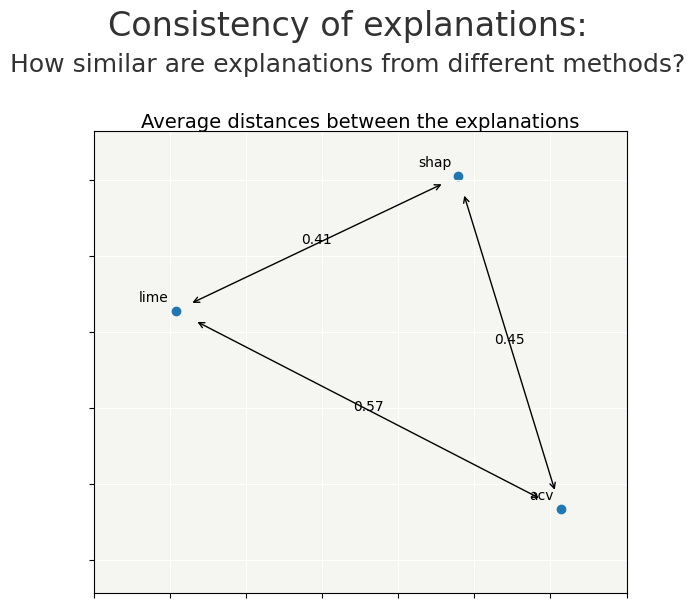

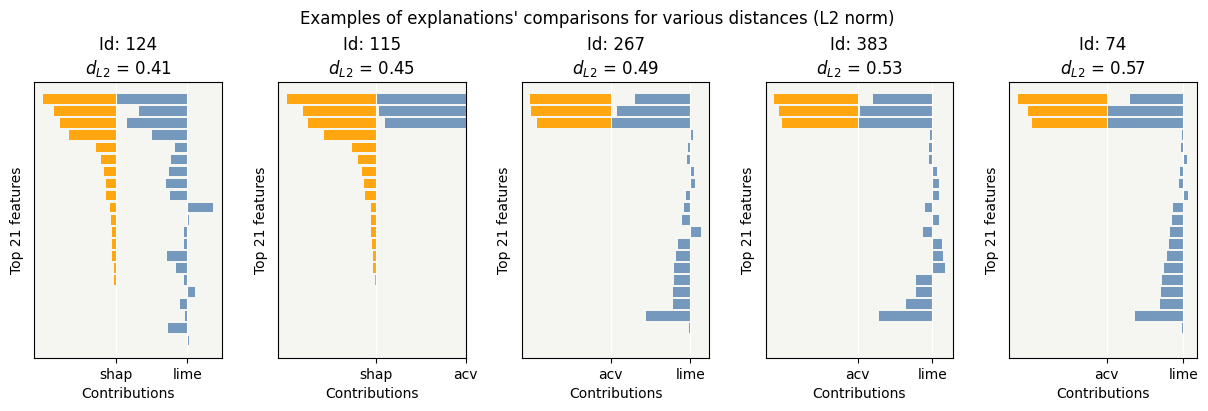

In [39]:
cns.consistency_plot(max_features=21)

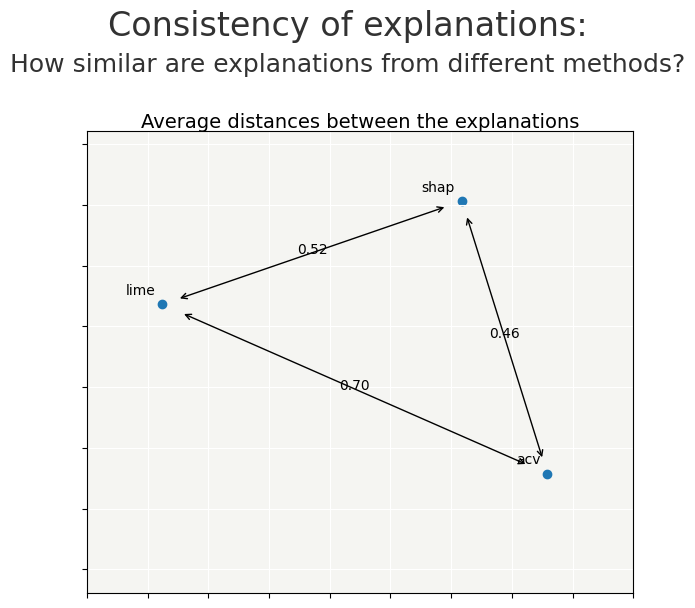

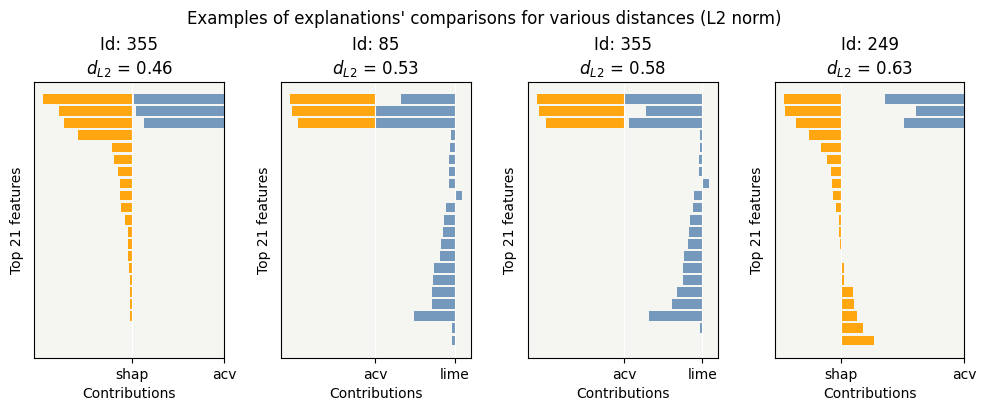

In [40]:
# index = X_test.index.tolist() -> error index out of bound ?
index = [1, 2, 3, 4, 5]
cns.consistency_plot(selection=index, max_features=21)

In [41]:
import shap

treeSHAP = shap.TreeExplainer(clf).shap_values(X_train, check_additivity=False)[1]
samplingSHAP = shap.SamplingExplainer(clf.predict_proba, shap.kmeans(X_train, 200)).shap_values(X_train, check_additivity=False)[1]
kernelSHAP = shap.KernelExplainer(clf.predict_proba, shap.kmeans(X_train, 200)).shap_values(X_train, check_additivity=False)[1]

treeSHAP = pd.DataFrame(treeSHAP, columns=X_train.columns)
samplingSHAP = pd.DataFrame(samplingSHAP, columns=X_train.columns)
kernelSHAP = pd.DataFrame(kernelSHAP, columns=X_train.columns)

  0%|                                                                                 | 0/267 [00:00<?, ?it/s]INFO:shap:num_full_subsets = 2
INFO:shap:remaining_weight_vector = [0.19492121 0.15479038 0.13157182 0.11695273 0.10740557 0.10120909
 0.09746061 0.0956886 ]
INFO:shap:num_paired_subset_sizes = 10
INFO:shap:weight_left = 0.554544872149051
INFO:shap:np.sum(w_aug) = 21.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [ 0.00379993  0.03863422  0.02975607  0.00030962  0.01351054  0.01352909
  0.          0.0062909   0.00396231  0.03099687  0.00180289 -0.00063103
  0.00106867 -0.00128217  0.          0.00400258 -0.00083932  0.04349744
  0.00394915  0.00294128  0.00531485]
INFO:shap:np.sum(w_aug) = 21.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [-0.00379993 -0.03863422 -0.02975607 -0.00030962 -0.01351054 -0.01352909
  0.         -0.0062909  -0.00396231 -0.03099687 -0.00180289  0.00063103
 -0.00106867  0.00128217  0.         -0.00400258  0.00083932 -0.0434

INFO:shap:np.sum(w_aug) = 21.0
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [-0.00448716 -0.03873327 -0.02968226 -0.0015578  -0.01391998 -0.01038161
 -0.00236796 -0.00722503 -0.00096591 -0.03236053 -0.00255676  0.
 -0.00161033  0.          0.          0.         -0.00133937 -0.0485833
  0.00124896  0.         -0.00609156]
  3%|██▏                                                                      | 8/267 [00:18<09:52,  2.29s/it]INFO:shap:num_full_subsets = 2
INFO:shap:remaining_weight_vector = [0.19492121 0.15479038 0.13157182 0.11695273 0.10740557 0.10120909
 0.09746061 0.0956886 ]
INFO:shap:num_paired_subset_sizes = 10
INFO:shap:weight_left = 0.554544872149051
INFO:shap:np.sum(w_aug) = 21.0
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [-0.0027957  -0.00938147 -0.01690492  0.01678459  0.01579036 -0.0100413
  0.00268933  0.00578142 -0.01080292  0.03779339  0.01327046  0.00974638
  0.00815783 -0.00244317 -0.00153794 -0.00182441

  6%|████                                                                    | 15/267 [00:34<09:32,  2.27s/it]INFO:shap:num_full_subsets = 2
INFO:shap:remaining_weight_vector = [0.19492121 0.15479038 0.13157182 0.11695273 0.10740557 0.10120909
 0.09746061 0.0956886 ]
INFO:shap:num_paired_subset_sizes = 10
INFO:shap:weight_left = 0.554544872149051
INFO:shap:np.sum(w_aug) = 21.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [ 0.00446932  0.03699543  0.02847643  0.00152334  0.01136509  0.01130597
  0.00150261  0.00628696  0.00389388  0.03112823  0.00171605  0.
  0.00095114 -0.00137431  0.00140619  0.0020456   0.00078736  0.04567391
  0.0034273   0.00311161  0.00592176]
INFO:shap:np.sum(w_aug) = 21.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [-0.00446932 -0.03699543 -0.02847643 -0.00152334 -0.01136509 -0.01130597
 -0.00150261 -0.00628696 -0.00389388 -0.03112823 -0.00171605  0.
 -0.00095114  0.00137431 -0.00140619 -0.0020456  -0.00078736 -0.04567391
 -0.0034273

INFO:shap:phi = [-0.00408824 -0.03640184 -0.02702324 -0.00053095 -0.01346979 -0.01333716
 -0.00069613 -0.00592743 -0.00653245 -0.02975609 -0.00289066  0.
 -0.00120252 -0.00019367 -0.00185321 -0.00426305 -0.00050919 -0.04091291
 -0.00354    -0.00301373 -0.00447161]
  9%|██████▏                                                                 | 23/267 [00:52<09:18,  2.29s/it]INFO:shap:num_full_subsets = 2
INFO:shap:remaining_weight_vector = [0.19492121 0.15479038 0.13157182 0.11695273 0.10740557 0.10120909
 0.09746061 0.0956886 ]
INFO:shap:num_paired_subset_sizes = 10
INFO:shap:weight_left = 0.554544872149051
INFO:shap:np.sum(w_aug) = 20.999999999999996
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [ 0.00915465 -0.15519336 -0.13341922  0.00885099 -0.0002197  -0.03682931
 -0.00169179 -0.05419873 -0.00264307 -0.08685846 -0.01691091 -0.00258591
 -0.00335828 -0.00486299 -0.00041612 -0.00461578  0.         -0.17101674
 -0.01975045 -0.00660293 -0.03871801]
INFO:shap:np.sum(w_aug) =

INFO:shap:np.sum(w_aug) = 21.0
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [-3.79831062e-03 -3.82329666e-02 -2.82233246e-02 -3.94072838e-04
 -1.35657117e-02 -1.32431155e-02 -8.26502377e-04 -6.03941953e-03
 -3.90051569e-03 -3.03023316e-02 -1.63638138e-03  0.00000000e+00
 -1.07330539e-03  0.00000000e+00 -7.13736608e-05 -3.84770285e-03
  0.00000000e+00 -4.34336909e-02 -4.09566378e-03 -2.76052994e-03
 -5.16895655e-03]
 12%|████████▎                                                               | 31/267 [01:11<09:20,  2.37s/it]INFO:shap:num_full_subsets = 2
INFO:shap:remaining_weight_vector = [0.19492121 0.15479038 0.13157182 0.11695273 0.10740557 0.10120909
 0.09746061 0.0956886 ]
INFO:shap:num_paired_subset_sizes = 10
INFO:shap:weight_left = 0.554544872149051
INFO:shap:np.sum(w_aug) = 21.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [ 0.00424357  0.03746614  0.03010316  0.00022869  0.01325347  0.01351239
  0.          0.00656191  0.00641033  0.

INFO:shap:phi = [-0.01882955  0.02708991  0.01313312 -0.00557511 -0.06997746 -0.00548459
 -0.01507547  0.00290145 -0.01319778 -0.10653491  0.00172177  0.01193549
 -0.00362073  0.00749564 -0.00074881 -0.01271153  0.0035459  -0.10101714
  0.02999206  0.00083798  0.0088527 ]
INFO:shap:np.sum(w_aug) = 21.0
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [ 0.01882955 -0.02708991 -0.01313312  0.00557511  0.06997746  0.00548459
  0.01507547 -0.00290145  0.01319778  0.10653491 -0.00172177 -0.01193549
  0.00362073 -0.00749564  0.00074881  0.01271153 -0.0035459   0.10101714
 -0.02999206 -0.00083798 -0.0088527 ]
 15%|██████████▌                                                             | 39/267 [01:30<09:03,  2.38s/it]INFO:shap:num_full_subsets = 2
INFO:shap:remaining_weight_vector = [0.19492121 0.15479038 0.13157182 0.11695273 0.10740557 0.10120909
 0.09746061 0.0956886 ]
INFO:shap:num_paired_subset_sizes = 10
INFO:shap:weight_left = 0.554544872149051
INFO:shap:np.sum

INFO:shap:num_paired_subset_sizes = 10
INFO:shap:weight_left = 0.554544872149051
INFO:shap:np.sum(w_aug) = 21.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [ 0.00464271  0.03874946  0.02939288  0.00076364  0.01397789  0.01152027
  0.00242883  0.0072697   0.00093895  0.03286456  0.00263004 -0.00076356
  0.00160264  0.          0.          0.          0.00121157  0.04862147
 -0.00128299  0.          0.0060458 ]
INFO:shap:np.sum(w_aug) = 21.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [-0.00464271 -0.03874946 -0.02939288 -0.00076364 -0.01397789 -0.01152027
 -0.00242883 -0.0072697  -0.00093895 -0.03286456 -0.00263004  0.00076356
 -0.00160264  0.          0.          0.         -0.00121157 -0.04862147
  0.00128299  0.         -0.0060458 ]
 18%|████████████▋                                                           | 47/267 [01:49<08:32,  2.33s/it]INFO:shap:num_full_subsets = 2
INFO:shap:remaining_weight_vector = [0.19492121 0.15479038 0.13157182 0.11695273 0.1

 20%|██████████████▌                                                         | 54/267 [02:06<08:33,  2.41s/it]INFO:shap:num_full_subsets = 2
INFO:shap:remaining_weight_vector = [0.19492121 0.15479038 0.13157182 0.11695273 0.10740557 0.10120909
 0.09746061 0.0956886 ]
INFO:shap:num_paired_subset_sizes = 10
INFO:shap:weight_left = 0.554544872149051
INFO:shap:np.sum(w_aug) = 21.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [ 0.00471179  0.03795152  0.03080736  0.00148764  0.01127341  0.01104802
  0.00233366  0.00701314  0.00162038  0.03240646  0.0014777  -0.00074738
  0.00157582  0.          0.          0.          0.00134968  0.05123912
  0.          0.          0.00506556]
INFO:shap:np.sum(w_aug) = 21.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [-0.00471179 -0.03795152 -0.03080736 -0.00148764 -0.01127341 -0.01104802
 -0.00233366 -0.00701314 -0.00162038 -0.03240646 -0.0014777   0.00074738
 -0.00157582  0.          0.          0.         -0.00134968 -0.0512

 23%|████████████████▋                                                       | 62/267 [02:25<08:14,  2.41s/it]INFO:shap:num_full_subsets = 2
INFO:shap:remaining_weight_vector = [0.19492121 0.15479038 0.13157182 0.11695273 0.10740557 0.10120909
 0.09746061 0.0956886 ]
INFO:shap:num_paired_subset_sizes = 10
INFO:shap:weight_left = 0.554544872149051
INFO:shap:np.sum(w_aug) = 21.0
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [ 0.00454352  0.03869276  0.03085493  0.00077498  0.01389092  0.01255552
  0.00233762  0.00736959  0.00316871  0.0320159   0.001126   -0.00074436
  0.00172371 -0.00128363  0.          0.00012458  0.00139986  0.04726632
 -0.0010353   0.          0.00583224]
INFO:shap:np.sum(w_aug) = 21.0
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [-0.00454352 -0.03869276 -0.03085493 -0.00077498 -0.01389092 -0.01255552
 -0.00233762 -0.00736959 -0.00316871 -0.0320159  -0.001126    0.00074436
 -0.00172371  0.00128363  0.         -

INFO:shap:np.sum(w_aug) = 21.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [-0.00521293 -0.03741471 -0.02951605 -0.00178352 -0.01348702 -0.01372552
 -0.00117875 -0.00646897 -0.00627204 -0.02955977 -0.00187238  0.00075071
 -0.00132086  0.00122672  0.         -0.00301433  0.         -0.04364953
 -0.00405072  0.         -0.00406422]
 26%|██████████████████▉                                                     | 70/267 [02:45<07:43,  2.35s/it]INFO:shap:num_full_subsets = 2
INFO:shap:remaining_weight_vector = [0.19492121 0.15479038 0.13157182 0.11695273 0.10740557 0.10120909
 0.09746061 0.0956886 ]
INFO:shap:num_paired_subset_sizes = 10
INFO:shap:weight_left = 0.554544872149051
INFO:shap:np.sum(w_aug) = 21.0
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [ 0.00468985  0.03870968  0.03081057  0.00075623  0.01385214  0.01253632
  0.00237011  0.00721663  0.00166449  0.0321029   0.00155552 -0.00074737
  0.00177155  0.          0.          0.          0.0

INFO:shap:np.sum(w_aug) = 21.0
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000004
INFO:shap:phi = [-0.00403869 -0.03644817 -0.02756295 -0.0002537  -0.01333049 -0.01349434
 -0.00090556 -0.00592923 -0.00626763 -0.03003984 -0.00244498  0.
 -0.00116406  0.00142409 -0.00162672 -0.00413305 -0.00124735 -0.04178317
 -0.00336261 -0.0031073  -0.00489812]
 29%|█████████████████████                                                   | 78/267 [03:04<07:35,  2.41s/it]INFO:shap:num_full_subsets = 2
INFO:shap:remaining_weight_vector = [0.19492121 0.15479038 0.13157182 0.11695273 0.10740557 0.10120909
 0.09746061 0.0956886 ]
INFO:shap:num_paired_subset_sizes = 10
INFO:shap:weight_left = 0.554544872149051
INFO:shap:np.sum(w_aug) = 21.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [ 0.00518596  0.03711336  0.02973349  0.00213546  0.01398225  0.01375289
  0.0024771   0.0071839   0.00567972  0.03007914  0.00114497 -0.00078912
  0.00178609 -0.00133787  0.          0.00014872  0.00139536 

INFO:shap:num_paired_subset_sizes = 10
INFO:shap:weight_left = 0.554544872149051
INFO:shap:np.sum(w_aug) = 20.999999999999996
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [-0.02255254  0.03980921  0.0224741  -0.00393723 -0.11888797 -0.0320758
 -0.01809521  0.00315079 -0.00258018 -0.16241427 -0.00497004  0.00219855
 -0.00439296 -0.00581946 -0.00239374 -0.042084    0.         -0.14573572
 -0.01689993 -0.02135418  0.00272207]
INFO:shap:np.sum(w_aug) = 20.999999999999996
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [ 0.02255254 -0.03980921 -0.0224741   0.00393723  0.11888797  0.0320758
  0.01809521 -0.00315079  0.00258018  0.16241427  0.00497004 -0.00219855
  0.00439296  0.00581946  0.00239374  0.042084    0.          0.14573572
  0.01689993  0.02135418 -0.00272207]
 32%|███████████████████████▏                                                | 86/267 [03:24<07:44,  2.57s/it]INFO:shap:num_full_subsets = 2
INFO:shap:remaining_weight_v

 35%|█████████████████████████                                               | 93/267 [03:43<07:38,  2.63s/it]INFO:shap:num_full_subsets = 2
INFO:shap:remaining_weight_vector = [0.19492121 0.15479038 0.13157182 0.11695273 0.10740557 0.10120909
 0.09746061 0.0956886 ]
INFO:shap:num_paired_subset_sizes = 10
INFO:shap:weight_left = 0.554544872149051
INFO:shap:np.sum(w_aug) = 21.0
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [ 0.00456435  0.03874976  0.03079061  0.00168339  0.01390512  0.0114251
  0.00236809  0.00725049  0.00154745  0.03238988  0.00132754 -0.00074614
  0.00182529  0.          0.          0.          0.00143711  0.04720325
 -0.00104191  0.          0.00593452]
INFO:shap:np.sum(w_aug) = 21.0
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [-0.00456435 -0.03874976 -0.03079061 -0.00168339 -0.01390512 -0.0114251
 -0.00236809 -0.00725049 -0.00154745 -0.03238988 -0.00132754  0.00074614
 -0.00182529  0.          0.          0.

 38%|██████████████████████████▊                                            | 101/267 [04:04<07:29,  2.71s/it]INFO:shap:num_full_subsets = 2
INFO:shap:remaining_weight_vector = [0.19492121 0.15479038 0.13157182 0.11695273 0.10740557 0.10120909
 0.09746061 0.0956886 ]
INFO:shap:num_paired_subset_sizes = 10
INFO:shap:weight_left = 0.554544872149051
INFO:shap:np.sum(w_aug) = 21.0
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000004
INFO:shap:phi = [ 0.0040121   0.03883471  0.03096231  0.00030064  0.01337219  0.01370308
  0.00267945  0.0068593   0.00386262  0.03105416  0.00313072 -0.00076566
  0.0011289  -0.00129183  0.00022397  0.          0.00036313  0.04332474
  0.00366318  0.00013914  0.00505702]
INFO:shap:np.sum(w_aug) = 21.0
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000004
INFO:shap:phi = [-0.0040121  -0.03883471 -0.03096231 -0.00030064 -0.01337219 -0.01370308
 -0.00267945 -0.0068593  -0.00386262 -0.03105416 -0.00313072  0.00076566
 -0.0011289   0.00129183 -0.00022397  

INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [-0.00452015 -0.03837256 -0.0313727  -0.00173023 -0.0124211  -0.01283158
 -0.00163261 -0.00737672 -0.00101966 -0.03358259 -0.00158261  0.00071981
 -0.00174566  0.          0.         -0.00023438 -0.00152733 -0.04864991
  0.00236587  0.00106756 -0.0061673 ]
 41%|████████████████████████████▉                                          | 109/267 [04:24<06:40,  2.54s/it]INFO:shap:num_full_subsets = 2
INFO:shap:remaining_weight_vector = [0.19492121 0.15479038 0.13157182 0.11695273 0.10740557 0.10120909
 0.09746061 0.0956886 ]
INFO:shap:num_paired_subset_sizes = 10
INFO:shap:weight_left = 0.554544872149051
INFO:shap:np.sum(w_aug) = 21.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [-0.02712939 -0.16825285 -0.11658155 -0.01358019 -0.0753056  -0.03929291
 -0.00354223 -0.00477667 -0.01191367 -0.12026125 -0.01253657 -0.00308751
 -0.00075127 -0.00021266 -0.00367342 -0.00164711 -0.00592814 -0.18536554
 -0.0094321

INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [ 0.00458548  0.03792279  0.0308373   0.00151639  0.01131695  0.0112917
  0.00249482  0.00725286  0.00160607  0.03240074  0.00151374 -0.00079008
  0.0017007   0.          0.          0.          0.00134662  0.05084104
 -0.00118597  0.          0.00596272]
INFO:shap:np.sum(w_aug) = 21.0
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [-0.00458548 -0.03792279 -0.0308373  -0.00151639 -0.01131695 -0.0112917
 -0.00249482 -0.00725286 -0.00160607 -0.03240074 -0.00151374  0.00079008
 -0.0017007   0.          0.          0.         -0.00134662 -0.05084104
  0.00118597  0.         -0.00596272]
 44%|███████████████████████████████                                        | 117/267 [04:45<06:23,  2.55s/it]INFO:shap:num_full_subsets = 2
INFO:shap:remaining_weight_vector = [0.19492121 0.15479038 0.13157182 0.11695273 0.10740557 0.10120909
 0.09746061 0.0956886 ]
INFO:shap:num_paired_subset_sizes = 10
IN

 46%|████████████████████████████████▉                                      | 124/267 [05:02<05:52,  2.46s/it]INFO:shap:num_full_subsets = 2
INFO:shap:remaining_weight_vector = [0.19492121 0.15479038 0.13157182 0.11695273 0.10740557 0.10120909
 0.09746061 0.0956886 ]
INFO:shap:num_paired_subset_sizes = 10
INFO:shap:weight_left = 0.554544872149051
INFO:shap:np.sum(w_aug) = 21.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [-0.00392869 -0.15072187 -0.14230526 -0.0056103  -0.00441164 -0.05176865
  0.         -0.06524176 -0.00532813  0.01047238  0.         -0.00227626
 -0.00304794 -0.00428415 -0.00200025 -0.00415577 -0.00337253 -0.21624285
 -0.02036908 -0.00587138 -0.05858867]
INFO:shap:np.sum(w_aug) = 21.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [ 0.00392869  0.15072187  0.14230526  0.0056103   0.00441164  0.05176865
  0.          0.06524176  0.00532813 -0.01047238  0.          0.00227626
  0.00304794  0.00428415  0.00200025  0.00415577  0.00337253  0.2162

 49%|███████████████████████████████████                                    | 132/267 [05:23<05:37,  2.50s/it]INFO:shap:num_full_subsets = 2
INFO:shap:remaining_weight_vector = [0.19492121 0.15479038 0.13157182 0.11695273 0.10740557 0.10120909
 0.09746061 0.0956886 ]
INFO:shap:num_paired_subset_sizes = 10
INFO:shap:weight_left = 0.554544872149051
INFO:shap:np.sum(w_aug) = 21.0
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [ 0.00458175  0.0373104   0.02831208  0.0006673   0.01142494  0.01266709
  0.00129998  0.00623752  0.00387937  0.03069472  0.00175828  0.
  0.00106381 -0.00133063  0.00135686  0.00201752  0.00034738  0.04577359
  0.0035685   0.00309009  0.00589333]
INFO:shap:np.sum(w_aug) = 21.0
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [-0.00458175 -0.0373104  -0.02831208 -0.0006673  -0.01142494 -0.01266709
 -0.00129998 -0.00623752 -0.00387937 -0.03069472 -0.00175828  0.
 -0.00106381  0.00133063 -0.00135686 -0.00201752 -0.00

 52%|█████████████████████████████████████▏                                 | 140/267 [05:42<05:07,  2.42s/it]INFO:shap:num_full_subsets = 2
INFO:shap:remaining_weight_vector = [0.19492121 0.15479038 0.13157182 0.11695273 0.10740557 0.10120909
 0.09746061 0.0956886 ]
INFO:shap:num_paired_subset_sizes = 10
INFO:shap:weight_left = 0.554544872149051
INFO:shap:np.sum(w_aug) = 20.999999999999996
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [ 0.00573615  0.03713134  0.02978113  0.00193547  0.01349688  0.01355664
  0.00244562  0.00665738  0.00553773  0.02995404  0.00239242  0.
  0.00106925 -0.00143988  0.          0.          0.00119447  0.04261084
  0.00452292  0.          0.00403147]
INFO:shap:np.sum(w_aug) = 20.999999999999996
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [-0.00573615 -0.03713134 -0.02978113 -0.00193547 -0.01349688 -0.01355664
 -0.00244562 -0.00665738 -0.00553773 -0.02995404 -0.00239242  0.
 -0.00106925  0.00143988  

 55%|███████████████████████████████████████▎                               | 148/267 [06:03<05:21,  2.70s/it]INFO:shap:num_full_subsets = 2
INFO:shap:remaining_weight_vector = [0.19492121 0.15479038 0.13157182 0.11695273 0.10740557 0.10120909
 0.09746061 0.0956886 ]
INFO:shap:num_paired_subset_sizes = 10
INFO:shap:weight_left = 0.554544872149051
INFO:shap:np.sum(w_aug) = 21.0
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [-0.00091862  0.04396952  0.03311252  0.00509686  0.01006525 -0.01548768
  0.00387721  0.00652964  0.00067643  0.03176987 -0.00290354 -0.00267822
  0.00096104  0.00094871  0.         -0.0078958   0.00430432  0.05851424
  0.00540228  0.          0.00693652]
INFO:shap:np.sum(w_aug) = 21.0
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [ 0.00091862 -0.04396952 -0.03311252 -0.00509686 -0.01006525  0.01548768
 -0.00387721 -0.00652964 -0.00067643 -0.03176987  0.00290354  0.00267822
 -0.00096104 -0.00094871  0.          

 58%|█████████████████████████████████████████▍                             | 156/267 [06:22<04:26,  2.40s/it]INFO:shap:num_full_subsets = 2
INFO:shap:remaining_weight_vector = [0.19492121 0.15479038 0.13157182 0.11695273 0.10740557 0.10120909
 0.09746061 0.0956886 ]
INFO:shap:num_paired_subset_sizes = 10
INFO:shap:weight_left = 0.554544872149051
INFO:shap:np.sum(w_aug) = 21.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [ 0.00510525  0.03715712  0.02878272  0.00183846  0.01376065  0.01372943
  0.0009258   0.00606826  0.00637464  0.02967178  0.0018409   0.
  0.00103386 -0.00109786  0.          0.0035346   0.          0.04525837
  0.00191175  0.00061141  0.00410674]
INFO:shap:np.sum(w_aug) = 21.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [-0.00510525 -0.03715712 -0.02878272 -0.00183846 -0.01376065 -0.01372943
 -0.0009258  -0.00606826 -0.00637464 -0.02967178 -0.0018409   0.
 -0.00103386  0.00109786  0.         -0.0035346   0.         -0.04525837
 -0.0019117

 61%|███████████████████████████████████████████▌                           | 164/267 [06:42<04:10,  2.43s/it]INFO:shap:num_full_subsets = 2
INFO:shap:remaining_weight_vector = [0.19492121 0.15479038 0.13157182 0.11695273 0.10740557 0.10120909
 0.09746061 0.0956886 ]
INFO:shap:num_paired_subset_sizes = 10
INFO:shap:weight_left = 0.554544872149051
INFO:shap:np.sum(w_aug) = 21.0
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [ 0.00537093  0.03757631  0.02944906  0.00174463  0.01346046  0.01355455
 -0.00079733  0.00642448  0.00649354  0.02954942  0.00177832 -0.00076063
  0.00106529 -0.00126222  0.         -0.00112962  0.          0.04549562
  0.00153376  0.          0.00440064]
INFO:shap:np.sum(w_aug) = 21.0
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [-0.00537093 -0.03757631 -0.02944906 -0.00174463 -0.01346046 -0.01355455
  0.00079733 -0.00642448 -0.00649354 -0.02954942 -0.00177832  0.00076063
 -0.00106529  0.00126222  0.          

 64%|█████████████████████████████████████████████▋                         | 172/267 [07:00<03:42,  2.34s/it]INFO:shap:num_full_subsets = 2
INFO:shap:remaining_weight_vector = [0.19492121 0.15479038 0.13157182 0.11695273 0.10740557 0.10120909
 0.09746061 0.0956886 ]
INFO:shap:num_paired_subset_sizes = 10
INFO:shap:weight_left = 0.554544872149051
INFO:shap:np.sum(w_aug) = 20.999999999999996
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [-0.02744556 -0.17303169 -0.10921574 -0.00489684 -0.08422832 -0.0429726
 -0.00573794  0.00200795 -0.02815051 -0.11787858 -0.00201754 -0.00270267
 -0.00033494 -0.0065537  -0.00291041 -0.00283761 -0.00177189 -0.17735035
 -0.00961004 -0.00174717  0.        ]
INFO:shap:np.sum(w_aug) = 20.999999999999996
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [ 0.02744556  0.17303169  0.10921574  0.00489684  0.08422832  0.0429726
  0.00573794 -0.00200795  0.02815051  0.11787858  0.00201754  0.00270267
  0.00033494

INFO:shap:np.sum(w_aug) = 21.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [ 0.01615522  0.17114332  0.10052242  0.00430462  0.06515296  0.04145576
  0.00487522  0.01723261  0.01773573  0.11473556  0.00073485  0.00127432
  0.01692476 -0.00406969  0.00251056  0.00466885  0.0009892   0.15169721
  0.00846544  0.01284655  0.02003065]
 67%|███████████████████████████████████████████████▊                       | 180/267 [07:19<03:21,  2.31s/it]INFO:shap:num_full_subsets = 2
INFO:shap:remaining_weight_vector = [0.19492121 0.15479038 0.13157182 0.11695273 0.10740557 0.10120909
 0.09746061 0.0956886 ]
INFO:shap:num_paired_subset_sizes = 10
INFO:shap:weight_left = 0.554544872149051
INFO:shap:np.sum(w_aug) = 21.0
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [ 0.00355776  0.03663337  0.02751914  0.          0.01367578  0.01348992
  0.0007734   0.00584957  0.00639179  0.0296674   0.00182844  0.
  0.00112535 -0.00088486  0.00163025  0.00405454  0.00017519 

INFO:shap:phi = [ 0.00358392 -0.16866496 -0.13809908 -0.00086012 -0.00622929 -0.04460791
  0.00132849 -0.02547204 -0.00586757 -0.10833922 -0.01515534 -0.00308386
 -0.01739727 -0.00506524 -0.00309407 -0.00580888  0.00305754 -0.14490912
 -0.024182   -0.00590572 -0.02494772]
INFO:shap:np.sum(w_aug) = 21.0
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [-0.00358392  0.16866496  0.13809908  0.00086012  0.00622929  0.04460791
 -0.00132849  0.02547204  0.00586757  0.10833922  0.01515534  0.00308386
  0.01739727  0.00506524  0.00309407  0.00580888 -0.00305754  0.14490912
  0.024182    0.00590572  0.02494772]
 70%|█████████████████████████████████████████████████▉                     | 188/267 [07:38<03:11,  2.43s/it]INFO:shap:num_full_subsets = 2
INFO:shap:remaining_weight_vector = [0.19492121 0.15479038 0.13157182 0.11695273 0.10740557 0.10120909
 0.09746061 0.0956886 ]
INFO:shap:num_paired_subset_sizes = 10
INFO:shap:weight_left = 0.554544872149051
INFO:shap:np.sum

INFO:shap:num_paired_subset_sizes = 10
INFO:shap:weight_left = 0.554544872149051
INFO:shap:np.sum(w_aug) = 21.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [-0.01134341 -0.16328909 -0.11466905 -0.00495453 -0.05979535 -0.04414069
  0.         -0.01563096 -0.01904694 -0.10441579 -0.00103871 -0.00291451
 -0.00021118 -0.00811325 -0.00269497 -0.00317726 -0.00267083 -0.18276703
 -0.00977516 -0.00395645 -0.02978097]
INFO:shap:np.sum(w_aug) = 21.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [0.01134341 0.16328909 0.11466905 0.00495453 0.05979535 0.04414069
 0.         0.01563096 0.01904694 0.10441579 0.00103871 0.00291451
 0.00021118 0.00811325 0.00269497 0.00317726 0.00267083 0.18276703
 0.00977516 0.00395645 0.02978097]
 73%|████████████████████████████████████████████████████                   | 196/267 [07:58<02:56,  2.49s/it]INFO:shap:num_full_subsets = 2
INFO:shap:remaining_weight_vector = [0.19492121 0.15479038 0.13157182 0.11695273 0.10740557 0.10120909
 0

 76%|█████████████████████████████████████████████████████▉                 | 203/267 [08:15<02:42,  2.54s/it]INFO:shap:num_full_subsets = 2
INFO:shap:remaining_weight_vector = [0.19492121 0.15479038 0.13157182 0.11695273 0.10740557 0.10120909
 0.09746061 0.0956886 ]
INFO:shap:num_paired_subset_sizes = 10
INFO:shap:weight_left = 0.554544872149051
INFO:shap:np.sum(w_aug) = 21.0
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [-0.0263915  -0.16861608 -0.10465387 -0.00809424 -0.08287203 -0.04299677
 -0.00277849 -0.00401887 -0.02667019 -0.12141542 -0.00175983 -0.00330134
 -0.00062357 -0.00714621 -0.00324235 -0.00192069 -0.00575412 -0.18175293
 -0.0100744   0.00565432 -0.00095755]
INFO:shap:np.sum(w_aug) = 21.0
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [ 0.0263915   0.16861608  0.10465387  0.00809424  0.08287203  0.04299677
  0.00277849  0.00401887  0.02667019  0.12141542  0.00175983  0.00330134
  0.00062357  0.00714621  0.00324235  

 79%|████████████████████████████████████████████████████████               | 211/267 [08:36<02:23,  2.57s/it]INFO:shap:num_full_subsets = 2
INFO:shap:remaining_weight_vector = [0.19492121 0.15479038 0.13157182 0.11695273 0.10740557 0.10120909
 0.09746061 0.0956886 ]
INFO:shap:num_paired_subset_sizes = 10
INFO:shap:weight_left = 0.554544872149051
INFO:shap:np.sum(w_aug) = 20.999999999999996
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [3.54651549e-03 3.64706957e-02 2.71115374e-02 8.29288717e-05
 1.35358486e-02 1.30435961e-02 7.15389231e-04 6.05428688e-03
 6.49872973e-03 2.95877541e-02 1.65269636e-03 0.00000000e+00
 1.24770154e-03 3.13620851e-04 1.66355785e-03 4.00071659e-03
 2.17026333e-04 4.24703750e-02 4.02941880e-03 3.20264609e-03
 5.16883404e-03]
INFO:shap:np.sum(w_aug) = 20.999999999999996
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [-3.54651549e-03 -3.64706957e-02 -2.71115374e-02 -8.29288717e-05
 -1.35358486e-02 -1.30435961e-02 -7.15389231e-04 -6.0542

INFO:shap:np.sum(w_aug) = 21.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [-0.00450173 -0.03878144 -0.02938623 -0.00060446 -0.01373827 -0.01145628
 -0.00220925 -0.00728565 -0.00094743 -0.03289852 -0.00262998  0.
 -0.00154052  0.          0.          0.         -0.00124873 -0.04852649
  0.0012086   0.         -0.0060675 ]
 82%|██████████████████████████████████████████████████████████▏            | 219/267 [08:57<02:07,  2.65s/it]INFO:shap:num_full_subsets = 2
INFO:shap:remaining_weight_vector = [0.19492121 0.15479038 0.13157182 0.11695273 0.10740557 0.10120909
 0.09746061 0.0956886 ]
INFO:shap:num_paired_subset_sizes = 10
INFO:shap:weight_left = 0.554544872149051
INFO:shap:np.sum(w_aug) = 21.0
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [0.00454389 0.03875289 0.03075855 0.00139294 0.010247   0.00993982
 0.00226587 0.00709255 0.00153264 0.03238935 0.00145289 0.
 0.00155131 0.         0.         0.         0.00116136 0.05239347
 0.         0.

INFO:shap:np.sum(w_aug) = 21.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [-0.00379446 -0.03810125 -0.02667979 -0.00018487 -0.01356268 -0.01358489
 -0.00077379 -0.00574299 -0.00389678 -0.03032449 -0.00183049  0.00090879
 -0.00098192 -0.00185032 -0.00163079 -0.00413536  0.         -0.04237953
 -0.00401781 -0.00289861 -0.00515186]
 85%|████████████████████████████████████████████████████████████▎          | 227/267 [09:18<01:46,  2.65s/it]INFO:shap:num_full_subsets = 2
INFO:shap:remaining_weight_vector = [0.19492121 0.15479038 0.13157182 0.11695273 0.10740557 0.10120909
 0.09746061 0.0956886 ]
INFO:shap:num_paired_subset_sizes = 10
INFO:shap:weight_left = 0.554544872149051
INFO:shap:np.sum(w_aug) = 21.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [ 0.00511435  0.03709612  0.02998741  0.0021342   0.01394939  0.01373494
  0.00242555  0.00693754  0.00614244  0.02980004  0.00116481 -0.00074483
  0.00187987 -0.00140669  0.          0.          0.00127403  0.0455

INFO:shap:np.sum(w_aug) = 21.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [ 0.02245108  0.18633474  0.12038597  0.01039552  0.0635432   0.03622803
  0.01072438 -0.00181743  0.01264892  0.12363826  0.0105237   0.00222734
  0.01564152 -0.00829835  0.00387634  0.00451457 -0.0029921   0.14302271
 -0.0049019   0.00320307 -0.0012968 ]
 88%|██████████████████████████████████████████████████████████████▍        | 235/267 [09:40<01:27,  2.73s/it]INFO:shap:num_full_subsets = 2
INFO:shap:remaining_weight_vector = [0.19492121 0.15479038 0.13157182 0.11695273 0.10740557 0.10120909
 0.09746061 0.0956886 ]
INFO:shap:num_paired_subset_sizes = 10
INFO:shap:weight_left = 0.554544872149051
INFO:shap:np.sum(w_aug) = 21.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [ 0.00464547  0.03819105  0.03062849  0.00170734  0.01395703  0.01143869
  0.00246613  0.00733689  0.00201014  0.03186658  0.00151238 -0.00082921
  0.00166059  0.          0.00141987  0.          0.0013056   0.0461

INFO:shap:np.sum(w_aug) = 21.0
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [0.00899045 0.17611195 0.11279587 0.00261963 0.06478353 0.04269133
 0.0014734  0.02558184 0.02726682 0.1046708  0.00112234 0.00107099
 0.01656072 0.00855706 0.00243834 0.00337498 0.00093823 0.15196341
 0.01100667 0.00560376 0.029764  ]
 91%|████████████████████████████████████████████████████████████████▌      | 243/267 [10:01<01:03,  2.66s/it]INFO:shap:num_full_subsets = 2
INFO:shap:remaining_weight_vector = [0.19492121 0.15479038 0.13157182 0.11695273 0.10740557 0.10120909
 0.09746061 0.0956886 ]
INFO:shap:num_paired_subset_sizes = 10
INFO:shap:weight_left = 0.554544872149051
INFO:shap:np.sum(w_aug) = 21.0
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [ 0.00520918  0.03727434  0.02958155  0.00171606  0.01349115  0.01368742
 -0.00080249  0.00664015  0.00646796  0.02955053  0.00181163 -0.00081768
  0.00118776 -0.00140763  0.         -0.00095407  0.       

INFO:shap:np.sum(w_aug) = 21.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [-0.00457391 -0.03885015 -0.03091441 -0.00153511 -0.01386542 -0.01143092
 -0.00248754 -0.00728878 -0.00158917 -0.03241664 -0.00154269  0.00077144
 -0.00169542  0.          0.          0.         -0.00131004 -0.04714912
  0.00124456  0.         -0.00598054]
 94%|██████████████████████████████████████████████████████████████████▋    | 251/267 [10:22<00:42,  2.67s/it]INFO:shap:num_full_subsets = 2
INFO:shap:remaining_weight_vector = [0.19492121 0.15479038 0.13157182 0.11695273 0.10740557 0.10120909
 0.09746061 0.0956886 ]
INFO:shap:num_paired_subset_sizes = 10
INFO:shap:weight_left = 0.554544872149051
INFO:shap:np.sum(w_aug) = 20.999999999999996
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [-0.01889499 -0.15367926 -0.13017078 -0.00255753  0.01231842 -0.03223364
 -0.00806162 -0.004301   -0.02725899 -0.147209   -0.01482384 -0.01239419
 -0.03562312 -0.00168986 -0.00597296 -0.00286957 -0.00

INFO:shap:np.sum(w_aug) = 21.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [-0.00642667 -0.04139022 -0.03474114 -0.00566275 -0.00915609  0.01785026
 -0.00034018 -0.00748359 -0.00079826 -0.03303469  0.00317929  0.00062852
 -0.00159037  0.          0.          0.         -0.00417926 -0.05813447
 -0.00075591  0.         -0.00714979]
 97%|████████████████████████████████████████████████████████████████████▊  | 259/267 [10:43<00:21,  2.64s/it]INFO:shap:num_full_subsets = 2
INFO:shap:remaining_weight_vector = [0.19492121 0.15479038 0.13157182 0.11695273 0.10740557 0.10120909
 0.09746061 0.0956886 ]
INFO:shap:num_paired_subset_sizes = 10
INFO:shap:weight_left = 0.554544872149051
INFO:shap:np.sum(w_aug) = 21.0
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [-0.02412221 -0.16750028 -0.1193793   0.00126793 -0.05757974 -0.04245119
 -0.00062131  0.00196374 -0.02051034 -0.11531836 -0.00244228 -0.00537303
 -0.00121134 -0.00778615 -0.00402416 -0.00226864 -0.0

INFO:shap:weight_left = 0.554544872149051
INFO:shap:np.sum(w_aug) = 21.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [0.00377992 0.03673825 0.02577165 0.00045532 0.01357544 0.0135144
 0.00064088 0.00546629 0.00630152 0.02997533 0.00167085 0.
 0.00109663 0.00184976 0.00145828 0.00395419 0.         0.04240188
 0.00396647 0.00280863 0.00518817]
INFO:shap:np.sum(w_aug) = 21.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [-0.00377992 -0.03673825 -0.02577165 -0.00045532 -0.01357544 -0.0135144
 -0.00064088 -0.00546629 -0.00630152 -0.02997533 -0.00167085  0.
 -0.00109663 -0.00184976 -0.00145828 -0.00395419  0.         -0.04240188
 -0.00396647 -0.00280863 -0.00518817]
100%|███████████████████████████████████████████████████████████████████████| 267/267 [11:05<00:00,  2.49s/it]


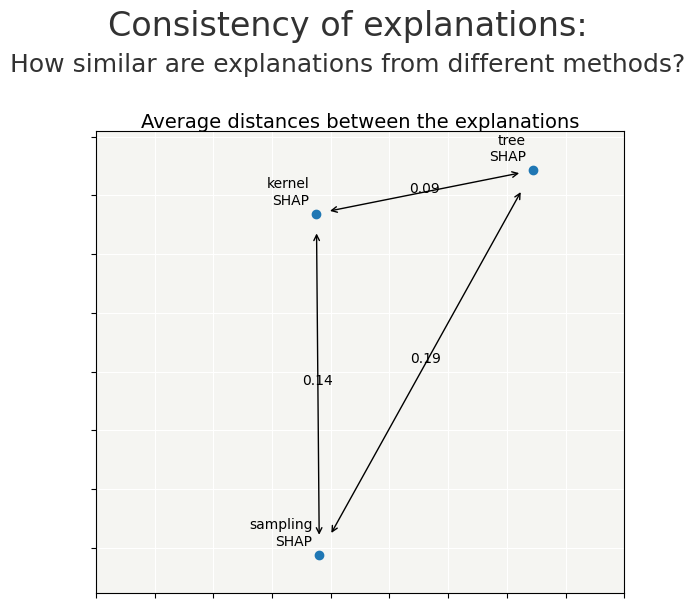

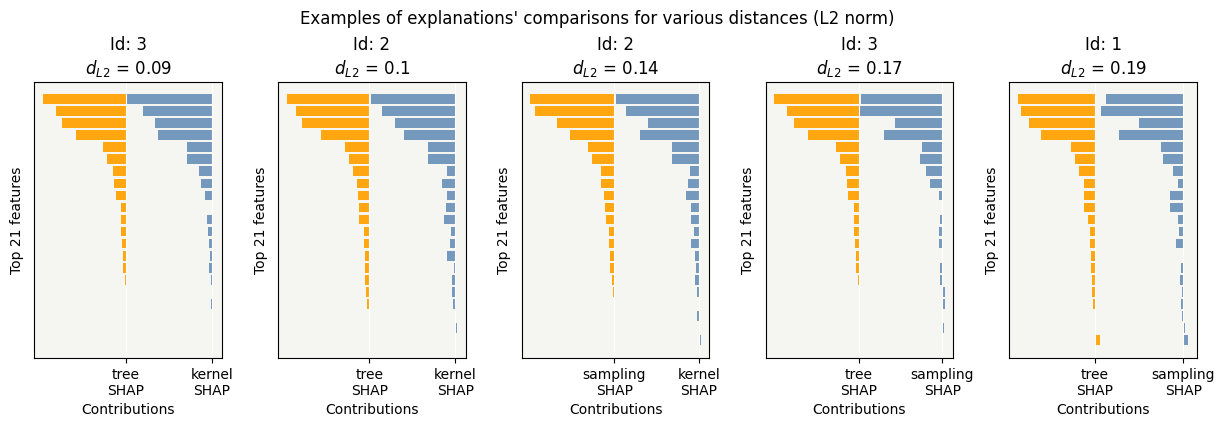

In [43]:
# The format must be a dictionary where keys are methods names and values are pandas DataFrames: be careful to have dataframes with same shape, index and column names
contributions = {"tree\nSHAP": treeSHAP, "sampling\nSHAP": samplingSHAP, "kernel\nSHAP":kernelSHAP}

index = [45, 36, 12, 17, 29]
cns = Consistency()
cns.compile(contributions=contributions,
            x=X_train[:50] #Optionnal, needed to display pairwise_consistency_plot
           )
cns.consistency_plot(selection=index, max_features=21)

In [44]:
response_dict = {1: 'Web', 2: 'Not Web'}
features = list(full_dataset.columns)
features_dict = dict(zip(features, features))
xpl = SmartExplainer(
    model=clf, 
    #preprocessing=encoder, 
    features_dict=features_dict, # Optional parameters
    label_dict=response_dict    # Optional parameters, dicts specify labels 
)
xpl.compile(x=X_train)
xpl.plot.compacity_plot()

In [45]:
index = [0, 1, 2]

xpl.plot.compacity_plot(selection=index, approx=.85, nb_features=3)

In [46]:
xpl.plot.stability_plot()

In [19]:
index = [1, 2, 3, 8, 9]

# Using distribution = "boxplot" or "violin" displays distributions of variability instead of means
xpl.plot.stability_plot(selection=index, max_features=5, distribution="boxplot")

In [47]:
xpl.plot.local_neighbors_plot(index=1)